## Finding Your Way In The City

In this notebook you'll combine the work of previous exercises to calculate a minimal series of waypoints in order to get from a start location to a goal location.

You'll reuse and modify your algorithms from:

- A*
- Configuration Space
- Collinearity and/or Bresenham

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid
from planning import a_star, heuristic, actual_path
from colinear import prune_path, collinearity_check, point
%matplotlib inline

#from bresenham import bresenham
from bresenham import bresenham

In [2]:
#testing modules
import argparse
import time
import msgpack
from enum import Enum, auto
import utm
import numpy as np

#from planning_utils import a_star, heuristic, create_grid
from planning import * #modified version of a_star containing diagonal movement, np.linalg.norm Heuristic
from grid import *
#from udacidrone import Drone
#from udacidrone.connection import MavlinkConnection
#from udacidrone.messaging import MsgID
#from udacidrone.frame_utils import global_to_local
from geo_ned import *  #to convert from geo to ned freely. vice versa
from colinear import * #contains prune_path and other useful definitions/functions/algorithms


In [3]:
plt.rcParams['figure.figsize'] = 12, 12

In [3]:
x = 

SyntaxError: invalid syntax (<ipython-input-3-0f44b287cd63>, line 1)

You'll notice we've imported `create_grid`, and `a_star`. These are functions you've implemented in previous exercises, and here you'll use them to create a map and find a path from a starting position to a goal position.

To read the function signature and documentation execute `?` followed by the function name in a cell. In the example below we'll check the documentation for `create_grid`.

In [3]:
?create_grid

If you would like to alter these implementations, you can modify [grid.py](/edit/grid.py) and [planning.py](/edit/planning.py) in the current directory.

In [4]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [5]:
# Static drone altitude (meters)
drone_altitude = 5

# Minimum distance stay away from obstacle (meters)
safe_distance = 3

In [6]:
# TODO: Use `create_grid` to create a grid configuration space of
# the obstacle data.
grid, north_min, east_min = create_grid(data, drone_altitude, safe_distance)

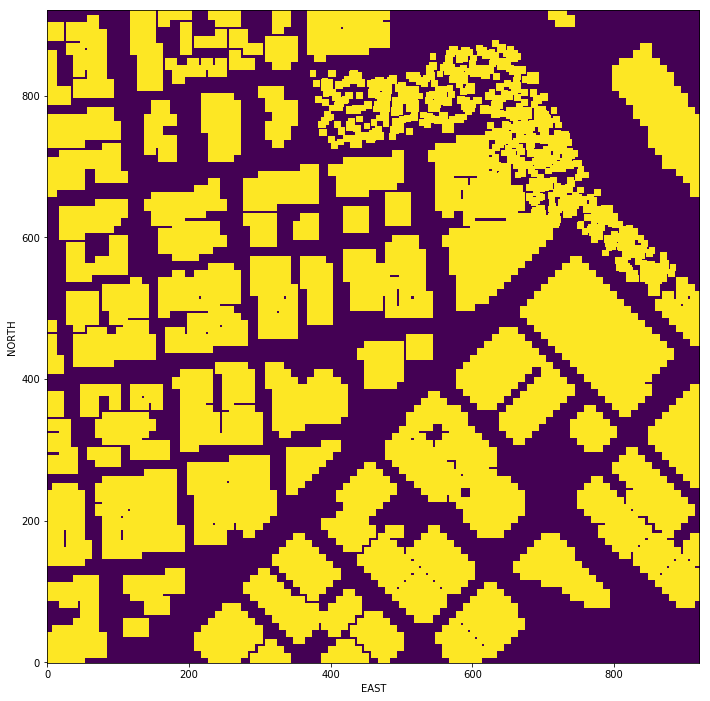

In [7]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower') 

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Next you'll compute the path from a start location to a goal location using A*.

Start and goal coordinates in *(north, east)*.

In [8]:
start_ne = (316, 445)
goal_ne = (326, 455)

Write a heuristic function.

In [9]:
def heuristic_func(position, goal_position):
    # TODO: write a heuristic approach!
    #Manhattan Graph or Euclidean Distance.
    #Manhattan is used in this approach
        
    return np.abs(goal_position[0] - position[0]) + np.abs(goal_position[1] - position[1])

Compute the lowest cost path with `a_star`. 

In [10]:
# TODO: use `a_star` to compute the lowest cost path
path, cost = a_star(grid, heuristic_func, start_ne, goal_ne)
print(len(path), cost)

Found a path.
11 14.142135623730955


In [11]:
print(path)

[(316, 445), (317, 446), (318, 447), (319, 448), (320, 449), (321, 450), (322, 451), (323, 452), (324, 453), (325, 454), (326, 455)]


Let's plot the path!

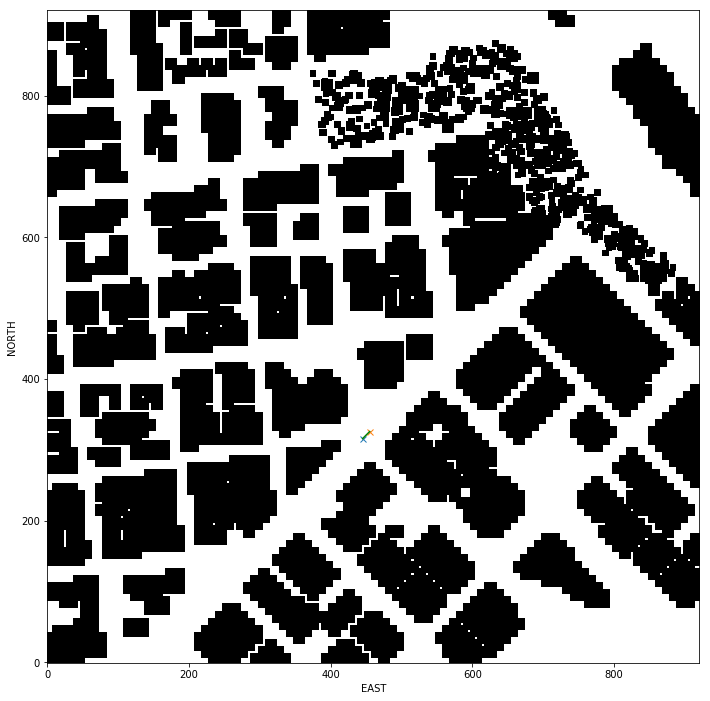

In [12]:
plt.imshow(grid, cmap='Greys', origin='lower')

#fix the plot error
#path = actual_path(actions, start_ne)


# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Pretty neat! Unfortunately this path is impractical, the drone would be constantly stopping and going since each grid cell visited is synonymous with a waypoint. Ideally, we'd like to only consider a new waypoint when the drone's direction changes. Path pruning is one way to achieve this result.

### Path Pruning

In [13]:
'''
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon
'''

'\ndef point(p):\n    return np.array([p[0], p[1], 1.]).reshape(1, -1)\n\ndef collinearity_check(p1, p2, p3, epsilon=1e-6):   \n    m = np.concatenate((p1, p2, p3), 0)\n    det = np.linalg.det(m)\n    return abs(det) < epsilon\n'

Complete the `prune_path` function below. It should return a new path much shorter than the original.

In [14]:
'''
# We're using collinearity here, but you could use Bresenham as well!
def prune_path(actual_path):
    #pruned_path = [p for p in actual_path]
    # TODO: prune the path!
    #startp = point(pruned_path[0])
    #goalp = point(pruned_path[len(pruned_path)-1])
    #bres_path = list(bresenham(startp[0], startp[1], goalp[0], goalp[1]))
    
    #return bres_path
    pruned_path = [p for p in actual_path]
    # TODO: prune the path!
    
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        
        #If the 3 points are in a line remove
        # the 2nd point.
        # The 3rd point now becomes and 2nd point
        # and the check is redone with a new third point
        # on the next iteration.
        if collinearity_check(p1, p2, p3):
            # Something subtle here but we can mutate
            # `pruned_path` freely because the length
            # of the list is check on every iteration.
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path
'''

"\n# We're using collinearity here, but you could use Bresenham as well!\ndef prune_path(actual_path):\n    #pruned_path = [p for p in actual_path]\n    # TODO: prune the path!\n    #startp = point(pruned_path[0])\n    #goalp = point(pruned_path[len(pruned_path)-1])\n    #bres_path = list(bresenham(startp[0], startp[1], goalp[0], goalp[1]))\n    \n    #return bres_path\n    pruned_path = [p for p in actual_path]\n    # TODO: prune the path!\n    \n    i = 0\n    while i < len(pruned_path) - 2:\n        p1 = point(pruned_path[i])\n        p2 = point(pruned_path[i+1])\n        p3 = point(pruned_path[i+2])\n        \n        #If the 3 points are in a line remove\n        # the 2nd point.\n        # The 3rd point now becomes and 2nd point\n        # and the check is redone with a new third point\n        # on the next iteration.\n        if collinearity_check(p1, p2, p3):\n            # Something subtle here but we can mutate\n            # `pruned_path` freely because the length\n        

Prune the path.

In [15]:
pruned_path = prune_path(path)
print(len(pruned_path))

2


In [16]:
pruned_path

[(316, 445), (326, 455)]

Replot the path, it will be the same as before but the drone flight will be much smoother.

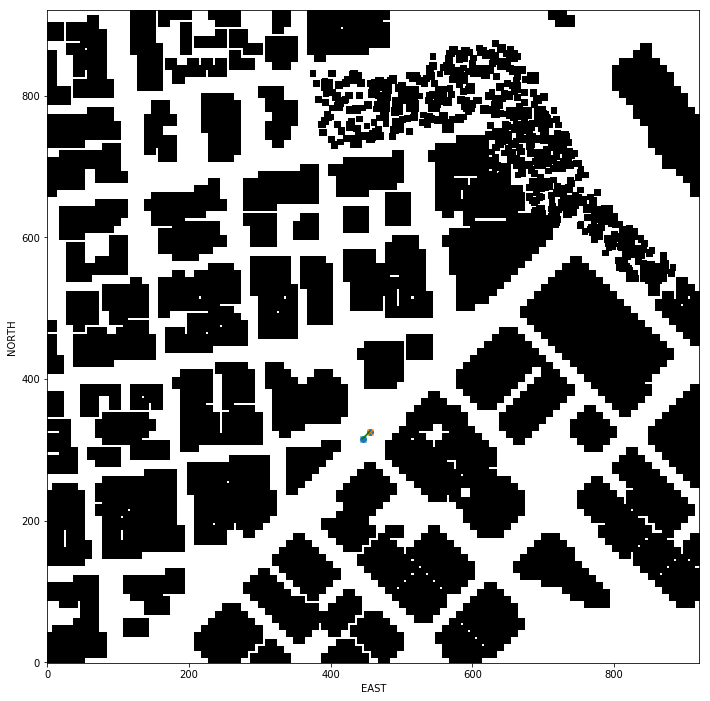

In [17]:
plt.imshow(grid, cmap='Greys', origin='lower')

plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(pruned_path)
plt.plot(pp[:, 1], pp[:, 0], 'g')
plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

Now the waypoints symbolize a change in direction, much better!

[solution](/notebooks/A-Star-City-Solution.ipynb)